In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])
sample = pd.read_csv("sample_submission.csv")

In [3]:
df = pd.concat([train, test], sort=False)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [5]:
df.describe([0.25, 0.50,0.75,0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
store,958000.0,5.500000,2.872283,1.0,3.00,5.5,8.00,10.00,10.0
item,958000.0,25.500000,14.430877,1.0,13.00,25.5,38.00,50.00,50.0
sales,913000.0,52.250287,28.801144,0.0,30.00,47.0,70.00,135.00,231.0
id,45000.0,22499.500000,12990.525394,0.0,11249.75,22499.5,33749.25,44549.01,44999.0


In [6]:
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3-Q1
alt_sinir = Q1- 1.5*IQR
ust_sinir = Q3 + 1.5*IQR

In [7]:
alt_sinir
ust_sinir

130.0

In [8]:
def ust_sinir_func(x):
    if x > ust_sinir:
        return ust_sinir
    else:
        return x
    
df["sales"] = df["sales"].apply(ust_sinir_func)

def alt_sinir_func(x):
    if x < alt_sinir:
        return alt_sinir
    else:
        return x
    
df["sales"] = df["sales"].apply(alt_sinir_func)

In [9]:
df.describe([0.25, 0.50, 0.75, 0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
store,958000.0,5.500000,2.872283,1.0,3.00,5.5,8.00,10.00,10.0
item,958000.0,25.500000,14.430877,1.0,13.00,25.5,38.00,50.00,50.0
sales,913000.0,52.067088,28.223040,0.0,30.00,47.0,70.00,130.00,130.0
id,45000.0,22499.500000,12990.525394,0.0,11249.75,22499.5,33749.25,44549.01,44999.0


In [10]:
df.nunique()

date      1916
store       10
item        50
sales      131
id       45000
dtype: int64

In [11]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [12]:
#Her store'da eşit sayıda mı eşsiz item var?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [13]:
df.groupby(["store"]).agg({"sales": ["sum"]})

,sales
,sum
store,
1,4314959.0
2,6052096.0
3,5414850.0
4,5004876.0
5,3631016.0
6,3627665.0
7,3320009.0
8,5811141.0


In [14]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135110.0  73.992333   73.0  19.795418

[500 rows x 4 columns]

In [15]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['quarter'] = df.date.dt.quarter
    df['is_q_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_q_start'] = df.date.dt.is_quarter_start.astype(int)
    df['days_in_month'] = df.date.dt.days_in_month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

df = create_date_features(df)
df.head(10)

,date,store,item,sales,id,month,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,0,1,31,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,1,0,0,31,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,1,0,0,31,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,1,0,0,31,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,1,0,0,31,5,5,1,5,2013,1,0,0
5,2013-01-06,1,1,12.0,NaN,1,1,0,0,31,6,6,1,6,2013,1,0,0
6,2013-01-07,1,1,10.0,NaN,1,1,0,0,31,7,7,2,0,2013,0,0,0
7,2013-01-08,1,1,9.0,NaN,1,1,0,0,31,8,8,2,1,2013,0,0,0
8,2013-01-09,1,1,12.0,NaN,1,1,0,0,31,9,9,2,2,2013,0,0,0
9,2013-01-10,1,1,9.0,NaN,1,1,0,0,31,10,10,2,3,2013,0,0,0


In [16]:
df.groupby(["store", "year","month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                       sum       mean median        std
store year month                                       
1     2013 1       41077.0  26.501290   25.0  12.491378
           2       41306.0  29.504286   28.0  14.070281
           3       55827.0  36.017419   34.0  16.617959
           4       61523.0  41.015333   40.0  18.816778
           5       69272.0  44.691613   43.0  20.407764
...                    ...        ...    ...        ...
10    2017 11     103486.0  68.990667   68.0  30.512608
           12      77850.0  50.225806   49.0  22.801739
      2018 1           0.0        NaN    NaN        NaN
           2           0.0        NaN    NaN        NaN
           3           0.0        NaN    NaN        NaN

[630 rows x 4 columns]

In [17]:
#Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [18]:
#Lag/shifted features
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [19]:
df.head()

,date,store,item,sales,id,month,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,0,1,31,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,1,0,0,31,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,1,0,0,31,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,1,0,0,31,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,1,0,0,31,5,5,1,5,2013,1,0,0


In [20]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [21]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [22]:
#periyorların belirlenmesi
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 456,546, 728,821])

In [23]:
df

,date,store,item,sales,id,month,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821
0,2013-01-01,1,1,13.0,NaN,1,1,0,1,31,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,1,0,0,31,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,1,0,0,31,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,1,0,0,31,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,1,0,0,31,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,1,0,0,31,27,86,13,1,2018,0,0,0,41.521459,52.760860,68.049268,66.103075,68.992582,82.811652,79.916895,59.095120,60.446077,99.963152,72.250815,58.550999
44996,2018-03-28,10,50,NaN,44996.0,3,1,0,0,31,28,87,13,2,2018,0,0,0,61.199985,48.835568,67.291295,59.610554,77.112437,78.799654,78.713417,71.150567,59.297432,78.712888,67.596723,42.710660
44997,2018-03-29,10,50,NaN,44997.0,3,1,0,0,31,29,88,13,3,2018,0,0,0,60.614142,61.378962,70.550549,66.042429,72.518799,86.140056,80.001461,65.443432,41.155730,95.646079,76.785605,46.138553
44998,2018-03-30,10,50,NaN,44998.0,3,1,0,0,31,30,89,13,4,2018,1,0,0,73.378191,73.715957,75.897790,65.677651,67.082133,80.545990,92.199045,66.602837,66.772293,77.552697,83.227594,48.811439


In [24]:
#rolling mean features
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [25]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [26]:
df = roll_mean_features(df, [365, 456,546])

In [27]:
df.head()

,date,store,item,sales,id,month,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,0,1,31,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,1,0,0,31,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,1,0,0,31,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,1,0,0,31,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,1,0,0,31,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df.tail()

,date,store,item,sales,id,month,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,1,0,0,31,27,86,13,1,2018,0,0,0,41.521459,52.760860,68.049268,66.103075,68.992582,82.811652,79.916895,59.095120,60.446077,99.963152,72.250815,58.550999,86.893999,87.922939,84.845894
44996,2018-03-28,10,50,NaN,44996.0,3,1,0,0,31,28,87,13,2,2018,0,0,0,61.199985,48.835568,67.291295,59.610554,77.112437,78.799654,78.713417,71.150567,59.297432,78.712888,67.596723,42.710660,89.478337,89.890358,83.280914
44997,2018-03-29,10,50,NaN,44997.0,3,1,0,0,31,29,88,13,3,2018,0,0,0,60.614142,61.378962,70.550549,66.042429,72.518799,86.140056,80.001461,65.443432,41.155730,95.646079,76.785605,46.138553,89.126256,90.516379,84.524448
44998,2018-03-30,10,50,NaN,44998.0,3,1,0,0,31,30,89,13,4,2018,1,0,0,73.378191,73.715957,75.897790,65.677651,67.082133,80.545990,92.199045,66.602837,66.772293,77.552697,83.227594,48.811439,88.587308,86.653278,86.519012
44999,2018-03-31,10,50,NaN,44999.0,3,1,1,0,31,31,90,13,5,2018,1,0,1,61.677929,70.713318,54.110113,67.718243,51.450141,77.434218,102.497975,96.352352,63.357703,96.259034,81.714989,43.180380,88.594156,88.896412,85.757363


In [29]:
#exponential weighted mean features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [30]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365,456,546, 728,821]

In [31]:
df = ewm_features(df, alphas, lags)

In [32]:
df.tail()

,date,store,item,sales,id,month,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821
44995,2018-03-27,10,50,NaN,44995.0,3,1,0,0,31,27,86,13,1,2018,0,0,0,41.521459,52.760860,68.049268,66.103075,68.992582,82.811652,79.916895,59.095120,60.446077,99.963152,72.250815,58.550999,86.893999,87.922939,84.845894,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,61.152327,94.617783,71.979468,57.660278,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,61.308273,92.561560,71.115472,58.242310,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,61.621252,89.361543,69.838571,59.176765,46.091666,55.909793,64.428121,65.144155,81.162051,112.055209,70.090358,61.911619,87.248414,69.116907,59.799906,51.309755,58.648702,64.033868,64.335072,80.828687,109.033862,71.734958,62.255584,85.489012,68.933911,59.962575
44996,2018-03-28,10,50,NaN,44996.0,3,1,0,0,31,28,87,13,2,2018,0,0,0,61.199985,48.835568,67.291295,59.610554,77.112437,78.799654,78.713417,71.150567,59.297432,78.712888,67.596723,42.710660,89.478337,89.890358,83.280914,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,60.057616,80.730889,68.198973,42.783014,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,60.130827,81.256156,68.311547,43.624231,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,60.324250,81.872309,68.367714,45.435353,57.927500,52.472938,66.228436,61.543247,87.348615,116.916563,63.027108,60.573486,82.174524,68.335072,47.339972,57.154878,54.824351,65.516934,62.167536,85.414343,114.016931,65.867479,61.127792,82.744506,68.466956,50.981287
44997,2018-03-29,10,50,NaN,44997.0,3,1,0,0,31,29,88,13,3,2018,0,0,0,60.614142,61.378962,70.550549,66.042429,72.518799,86.140056,80.001461,65.443432,41.155730,95.646079,76.785605,46.138553,89.126256,90.516379,84.524448,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,43.852881,98.086544,74.659949,44.889151,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,44.713083,97.225616,74.331155,44.862423,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,46.464850,95.574462,73.673543,45.087071,58.678250,59.841881,70.

In [33]:
df.shape

(958000, 88)

In [34]:
df.columns

Index(['date', 'store', 'item', 'sales', 'id', 'month', 'quarter', 'is_q_end', 'is_q_start', 'days_in_month', 'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week', 'year', 'is_wknd', 'is_month_start', 'is_month_end', 'sales_lag_91', 'sales_lag_98', 'sales_lag_105', 'sales_lag_112', 'sales_lag_119', 'sales_lag_126', 'sales_lag_182', 'sales_lag_364', 'sales_lag_456', 'sales_lag_546', 'sales_lag_728', 'sales_lag_821', 'sales_roll_mean_365', 'sales_roll_mean_456', 'sales_roll_mean_546',
       'sales_ewm_alpha_095_lag_91', 'sales_ewm_alpha_095_lag_98', 'sales_ewm_alpha_095_lag_105', 'sales_ewm_alpha_095_lag_112', 'sales_ewm_alpha_095_lag_180', 'sales_ewm_alpha_095_lag_270', 'sales_ewm_alpha_095_lag_365', 'sales_ewm_alpha_095_lag_456', 'sales_ewm_alpha_095_lag_546', 'sales_ewm_alpha_095_lag_728', 'sales_ewm_alpha_095_lag_821', 'sales_ewm_alpha_09_lag_91', 'sales_ewm_alpha_09_lag_98', 'sales_ewm_alpha_09_lag_105', 'sales_ewm_alpha_09_lag_112', 'sales_ewm_alpha_09_lag_180',
       'sa

In [35]:
#one hot encoding
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'], drop_first=True)

In [36]:
df.head()

,date,sales,id,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,0,1,31,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,1,0,0,31,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,1,0,0,31,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,1,0,0,31,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [37]:
#logaritmic transformation
df['sales'] = np.log1p(df["sales"].values)

In [38]:
df.head()

,date,sales,id,quarter,is_q_end,is_q_start,days_in_month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_456,sales_lag_546,sales_lag_728,sales_lag_821,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_456,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_095_lag_821,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_456,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_821,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_456,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_08_lag_821,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_456,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_07_lag_821,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_456,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_05_lag_821,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,0,1,31,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,1,0,0,31,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,1,0,0,31,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,1,0,0,31,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,Na

In [39]:
#custom cost function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [41]:
train = df.loc[(df["date"] < "2017-01-01"), :]

In [42]:
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [43]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [45]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [46]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 155), (45000,), (45000, 155))

In [47]:
#light gbm model
lgb_params =  { 'metric': 'mae',
                'num_leaves' : 12,
                'max_depth': 10,
                'min_child_samples': 5,
                'learning_rate': 0.03,
                'colsample_bytree': 0.5,
                'verbose': 0,
                'num_boost_round': 2000,
                'early_stopping_rounds': 200,
                'min_child_weight' : 0.1,
                'nthread': -1}

In [48]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.393585 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.150343	training's SMAPE: 15.3817	valid_1's l1: 0.153137	valid_1's SMAPE: 15.6916
[200]	training's l1: 0.136858	training's SMAPE: 14.0303	valid_1's l1: 0.142714	valid_1's SMAPE: 14.6478
[300]	training's l1: 0.133585	training's SMAPE: 13.7033	valid_1's l1: 0.14012	valid_1's SMAPE: 14.3871
[400]	training's l1: 0.131912	training's SMAPE: 13.5358	valid_1's l1: 0.138431	valid_1's SMAPE: 14.2171
[500]	training's l1: 0.130762	training's SMAPE: 13.4203	valid_1's l1: 0.137191	valid_1's SMAPE: 14.0921
[600]	training's l1: 0.129942	training's SMAPE: 13.3379	valid_1's l1: 0.13637	valid_1's SMAPE: 14.0093
[700]	training's l1: 0.129242	training's SMAPE: 13.2675	valid_1's l1: 0.135666	valid_1's SMAPE: 13.9383
[800]	training's l1: 0.128695	training's SMAPE:

In [49]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.695233139901415

In [50]:
#feature importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

In [53]:
plot_lgb_importances(model, num=30)

                         feature  split       gain
24           sales_roll_mean_546   1366  35.076913
23           sales_roll_mean_456   1019  20.606112
17                 sales_lag_364   2096  12.094503
58     sales_ewm_alpha_07_lag_91    118   6.211838
22           sales_roll_mean_365    932   2.831840
75    sales_ewm_alpha_05_lag_365    337   2.626817
53    sales_ewm_alpha_08_lag_365    210   1.966646
25    sales_ewm_alpha_095_lag_91    192   1.815111
5                    day_of_year   1450   1.719624
10                  sales_lag_91    379   1.516769
6                   week_of_year    674   1.475679
7                        is_wknd    515   1.422543
47     sales_ewm_alpha_08_lag_91    149   1.397822
42    sales_ewm_alpha_09_lag_365    367   1.172352
64    sales_ewm_alpha_07_lag_365    174   0.885931
11                  sales_lag_98    130   0.838980
154                     month_12    339   0.694901
0                        quarter    313   0.567215
56    sales_ewm_alpha_08_lag_72

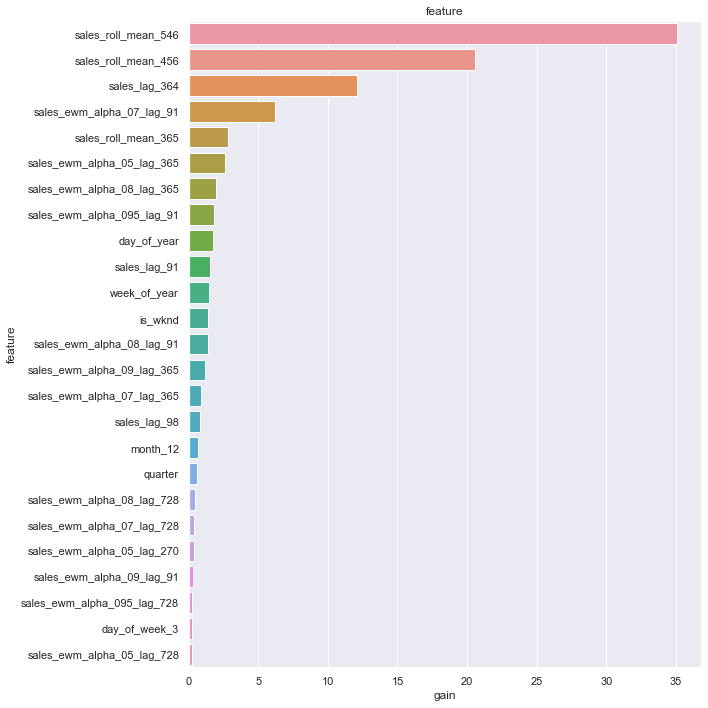

In [54]:
plot_lgb_importances(model, num=30,plot=True)

In [57]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [69]:
lgb_params = { 'metric': 'mae',
                'num_leaves' : 12,
                'max_depth': 10,
                'min_child_samples': 5,
                'learning_rate': 0.03,
                'colsample_bytree': 0.5,
                'verbose': 0,
                'min_child_weight' : 0.1,
                'nthread': -1,
                "num_boost_round": 2000}

In [70]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [71]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.471729 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [72]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [73]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.695233139901415

In [74]:
test_preds

array([2.61801349, 3.68381362, 4.14793778, ..., 2.8487074 , 4.21257543,
       4.4572397 ])